In [1]:
!python -V

Python 3.7.3


In [3]:
import pickle
import random
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score,make_scorer
#from sklearn.metrics.scorer import make_scorer

from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)

Numpy version: 1.16.5
Pandas version: 0.24.2


In [4]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

#scikit-learn package (https://pypi.org/project/scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
#from sklearn.metrics.scorer import make_scorer

#eli5 package (https://eli5.readthedocs.io/en/latest)
import eli5
from eli5.sklearn import PermutationImportance

#lime package (https://github.com/marcotcr/lime)
import lime
import lime.lime_tabular

#shap package (https://github.com/slundberg/shap)
import shap

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [5]:
# %matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 18

In [6]:
df = pd.read_excel(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Data\148CA_EN20210701.xlsx')

df.head()

,Gender,Age_value,BMI_value,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA_PS,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage_ml,Blood_transfusion_ml,Epinephrine_mg,Atropine_mg,Amiodarone_g,Ephedrine_mg,Methoxamine_mg,CPR_min,Died
0,Female,46.0,23.738662,0,0,0,0,0,0,1,0,Abdominal,0,0,General,Supine,2,Intubation,0,Anesthesia,0,0,0.00,0.0,0.00,0.0,0.0,0.16,0
1,Male,72.0,24.341758,0,0,0,0,0,0,0,0,Thoracic,0,0,General,Right lateral decubitus,2,Surgery,1,Unknown,1000,650,25.30,0.0,0.30,0.0,0.0,125.00,1
2,Male,56.0,24.034610,0,0,0,0,0,0,0,1,Neurosurgery,0,0,General,Left lateral decubitus,2,Surgery,1,Surgery,150,0,0.03,0.0,0.15,0.0,0.0,21.00,0
3,Female,64.0,29.048656,0,0,0,0,0,0,0,0,Abdominal,0,0,General,Supine,2,Surgery,0,Anesthesia,200,0,0.00,0.0,0.00,0.0,0.0,0.50,0
4,Male,68.0,28.081633,0,0,0,0,0,0,0,0,Abdominal,1,0,General,Supine,3,Surgery,1,Surgery,0,0,7.50,0.0,0.00,6.0,0.0,180.00,1


In [7]:
df['Age']='<12'
#df['Age']='>=65'
df.loc[(df['Age_value'] >= 12) & (df['Age_value'] < 40), 'Age'] = '12~40'
#df.loc[(df['Age_value'] < 40), 'Age'] = '<40'
df.loc[(df['Age_value'] >= 40) & (df['Age_value'] < 65), 'Age'] = '40~65'
df.loc[(df['Age_value'] >= 65), 'Age'] = '>=65'
#df.loc[(df['Age_value'] <=5), 'Age'] = '<=5'

df['BMI']='Underweight'
df.loc[(df['BMI_value'] >= 19) & (df['BMI_value'] < 24), 'BMI'] = 'Ideal'
df.loc[(df['BMI_value'] >= 24) & (df['BMI_value'] < 28), 'BMI'] = 'Overweight'
df.loc[(df['BMI_value'] >= 28), 'BMI'] = 'Obese'

df['ASA']='I-III'
df.loc[(df['ASA_PS'] >= 4), 'ASA'] = 'IV-V'


#df['Hemorrhage']='0'
df['Hemorrhage'] = '<200'
df.loc[(df['Hemorrhage_ml'] >= 200) & (df['Hemorrhage_ml'] < 800), 'Hemorrhage'] = '200~800'
df.loc[(df['Hemorrhage_ml'] >= 800), 'Hemorrhage'] = '>=800'

#df['Blood_transfusion']='0'
df['Blood_transfusion'] = '<200'
df.loc[(df['Blood_transfusion_ml'] >= 200) & (df['Blood_transfusion_ml'] < 800), 'Blood_transfusion'] = '200~800'
df.loc[(df['Blood_transfusion_ml'] >= 800), 'Blood_transfusion'] = '>=800'

df['Epinephrine']='0'
df.loc[(df['Epinephrine_mg'] > 0) & (df['Epinephrine_mg'] <= 5), 'Epinephrine'] = '<=5'
df.loc[(df['Epinephrine_mg'] > 5), 'Epinephrine'] = '>5'

df['Atropine']='0'
df.loc[(df['Atropine_mg'] > 0) & (df['Atropine_mg'] <= 0.65), 'Atropine'] = '<=0.65'
df.loc[(df['Atropine_mg'] > 0.65), 'Atropine'] = '>0.65'

df['Amiodarone']='0'
#df.loc[(df['Amiodarone_g'] > 0) & (df['Amiodarone_g'] <= 0.11), 'Amiodarone'] = '<=0.11'
df.loc[(df['Amiodarone_g'] > 0), 'Amiodarone'] = '0.04~0.3'
        
df['Ephedrine']='0'
#df.loc[(df['Ephedrine_mg'] > 0) & (df['Ephedrine_mg'] <= 6), 'Ephedrine'] = '<=6'
df.loc[(df['Ephedrine_mg'] > 0), 'Ephedrine'] = '6~15'
        
df['Methoxamine']='0'
#df.loc[(df['Methoxamine_mg'] > 0) & (df['Methoxamine_mg'] <= 3), 'Methoxamine'] = '<=3'
df.loc[(df['Methoxamine_mg'] > 0), 'Methoxamine'] = '1~35'
   
#df['CPR']='0'
#df.loc[(df['CPR_min'] > 0) & (df['CPR_min'] < 30), 'CPR'] = '<=30'
df.loc[(df['CPR_min'] < 30), 'CPR'] = '<30'
df.loc[(df['CPR_min'] >= 30) & (df['CPR_min'] < 60), 'CPR'] = '30~60'
df.loc[(df['CPR_min'] >= 60), 'CPR'] = '>=60'


df2=df[["Gender","Age","BMI","Comorbidity_diabetes","Comorbidity_hypertension","Comorbidity_CAD",
"Comorbidity_pulmonary","Comorbidity_hepatic","Comorbidity_renal","Comorbidity_neurological",
"Comorbidity_tumor","Surgical_type","Emergency","Trauma","Anaesthetic_type","Operative_position",
"ASA","Timing_arrest","Defibrillate","Cause_arrest","Hemorrhage","Blood_transfusion",
"Epinephrine","Atropine","Amiodarone","Ephedrine","Methoxamine","CPR","Died"]]


df2.head()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 29 columns):
Gender                      147 non-null object
Age                         147 non-null object
BMI                         147 non-null object
Comorbidity_diabetes        147 non-null int64
Comorbidity_hypertension    147 non-null int64
Comorbidity_CAD             147 non-null int64
Comorbidity_pulmonary       147 non-null int64
Comorbidity_hepatic         147 non-null int64
Comorbidity_renal           147 non-null int64
Comorbidity_neurological    147 non-null int64
Comorbidity_tumor           147 non-null int64
Surgical_type               147 non-null object
Emergency                   147 non-null int64
Trauma                      147 non-null int64
Anaesthetic_type            147 non-null object
Operative_position          147 non-null object
ASA                         147 non-null object
Timing_arrest               147 non-null object
Defibrillate                147 non-null 

In [8]:
df=df2

In [9]:
X=df
X['Gender'] = X.Gender.map({'Male':1, 'Female':0}) # M -> 1, F -> 0
X['Age'] = X.Age.map({'<12':0,'12~40':1,'40~65':2,'>=65':3}) # 
X['BMI'] = X.BMI.map({'Underweight':0, 'Ideal':1,'Overweight':2,'Obese':3}) # 
X['ASA'] = X.ASA.map({'I-III':0, 'IV-V':1}) # 
X['Hemorrhage'] = X.Hemorrhage.map({'<200':0, '200~800':1,'>=800':2}) # 
X['Blood_transfusion'] = X.Blood_transfusion.map({'<200':0, '200~800':1,'>=800':2}) # 
X['Epinephrine'] = X.Epinephrine.map({'0':0, '<=5':1,'>5':2}) # 
X['Atropine'] = X.Atropine.map({'0':0, '<=0.65':1,'>0.65':2}) # 
X['Amiodarone'] = X.Amiodarone.map({'0':0, '0.04~0.3':1}) # 
X['Ephedrine'] = X.Ephedrine.map({'0':0, '6~15':1}) # 
X['Methoxamine'] = X.Methoxamine.map({'0':0, '1~35':1}) # 
X['CPR'] = X.CPR.map({'<30':0,'30~60':1,'>=60':2}) # 
X['Surgical_type'] = X.Surgical_type.map({'Abdominal':0, 'Neurosurgery':1,'Orthopedics':2,'Thoracic':3,'Throat':4,'Others':5}) 
        # Abdominal->0, Neurosurgery->1,Thoracic->3,Throat->4,Others->5
X['Anaesthetic_type'] = X.Anaesthetic_type.map({'General':1, 'Local':0}) # General -> 1, Local -> 0
X['Operative_position'] = X.Operative_position.map({'Left lateral decubitus':0, 'Right lateral decubitus':1,'Prone':2,
                                                           'Lithotomy':3,'Supine':4}) # 
X['Timing_arrest'] = X.Timing_arrest.map({'Induction':0, 'Intubation':1,'Surgery':2,'NotAvaliable':3}) #
X['Cause_arrest'] = X.Cause_arrest.map({'Anesthesia':0, 'Comorbidity':1,'Surgery':2,'Unknown':3}) # M -> 1, F -> 0
df=X

In [10]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
#Now split the data into training and test set(85-15 split)
data_train, data_test = train_test_split(df, test_size=.25,
                                         stratify=df.Gender, random_state=42)

In [12]:
data_train.head()

,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR,Died
81,0,1,1,0,0,0,1,1,0,0,0,0,1,0,1,4,0,2,0,0,0,0,1,0,0,0,0,0,0
114,0,1,3,0,1,0,0,0,1,0,0,0,1,0,1,4,0,2,1,3,1,0,1,0,0,0,0,0,0
98,0,2,1,0,0,0,0,0,0,0,1,4,0,0,1,4,0,2,0,2,0,0,1,1,0,0,0,0,0
129,1,2,2,0,0,0,0,1,0,1,1,0,0,0,1,4,0,2,1,2,0,0,0,0,1,1,1,0,0
31,1,3,1,0,0,0,1,0,1,0,0,1,1,1,1,4,1,1,0,0,0,0,0,1,0,1,0,0,1


In [13]:
categorical_vars = ["Gender","Age","BMI","Comorbidity_diabetes","Comorbidity_hypertension","Comorbidity_CAD",
"Comorbidity_pulmonary","Comorbidity_hepatic","Comorbidity_renal","Comorbidity_neurological",
"Comorbidity_tumor","Surgical_type","Emergency","Trauma","Anaesthetic_type","Operative_position",
"ASA","Timing_arrest","Defibrillate","Cause_arrest","Hemorrhage","Blood_transfusion",
"Epinephrine","Atropine","Amiodarone","Ephedrine","Methoxamine","CPR"]

In [14]:
categorical_var_idxs = [idx for idx, _ in enumerate(list(data_train.columns)) if _ in categorical_vars]
print(categorical_var_idxs) 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [15]:
categorical_vars2 = ["Gender","Age","BMI","Comorbidity_diabetes","Comorbidity_hypertension","Comorbidity_CAD",
"Comorbidity_pulmonary","Comorbidity_hepatic","Comorbidity_renal","Comorbidity_neurological",
"Comorbidity_tumor","Surgical_type","Emergency","Trauma","Anaesthetic_type","Operative_position",
"ASA","Timing_arrest","Defibrillate","Cause_arrest","Hemorrhage","Blood_transfusion",
"Epinephrine","Atropine","Amiodarone","Ephedrine","Methoxamine","CPR","Died"]

In [16]:
categorical_var_idxs2 = [idx for idx, _ in enumerate(list(data_train.columns)) if _ in categorical_vars2]
print(categorical_var_idxs2) 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


In [17]:
# to make a custom transformer to fit into a pipeline
class Vars_selector(BaseEstimator, TransformerMixin):
    '''Return a subset of variables in a numpy array based on indecies'''
    def __init__(self, var_idxs):
        '''var_idxs is a list of categorical variables indecies'''
        self.var_idxs = var_idxs
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''returns a dataframe with selected variables'''
        return np.array(X)[:, self.var_idxs]

In [18]:
class Cat_vars_encoder(BaseEstimator, TransformerMixin):
    '''Return the transformed categorical variables based on indecies'''
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # arf column index
        # arf_idx = categorical_vars.index('arf')
        # X[:, arf_idx] = np.array(pd.Series(X[:, arf_idx]).map({1:1, 2:0})) # 1 -> Yes(1), 2 -> No(0)
        return X

In [19]:
# categorical variables preprocessing
cat_vars_pipeline = Pipeline([
    ('selector', Vars_selector(categorical_var_idxs)),
    ('encoder', Cat_vars_encoder())
])

In [20]:
# categorical variables preprocessing
cat_vars_pipeline2 = Pipeline([
    ('selector', Vars_selector(categorical_var_idxs2)),
    ('encoder', Cat_vars_encoder())
])

In [21]:
continuous_vars = [] #['Age', 'BMI', 'Hemorrhage_ml', 'Blood_transfusion', 'Epinephrine_mg', 'Atropine_mg',
       #'Amiodarone_g', 'Ephedrine_mg', 'Methoxamine_mg', 'CPR_min']

In [22]:
preproc_pipeline = FeatureUnion(transformer_list=[
    ('cat_pipeline', cat_vars_pipeline)
    #,('cont_pipeline', cont_vars_pipeline)
])

In [23]:
preproc_pipeline2 = FeatureUnion(transformer_list=[
    ('cat_pipeline', cat_vars_pipeline2)
    #,('cont_pipeline', cont_vars_pipeline)
])

In [24]:
data_train_X = pd.DataFrame(preproc_pipeline.fit_transform(data_train), 
                            columns=categorical_vars + continuous_vars)

In [25]:
data_train_X2 = pd.DataFrame(preproc_pipeline2.fit_transform(data_train), 
                            columns=categorical_vars2 + continuous_vars)

In [26]:
data_test_X = pd.DataFrame(preproc_pipeline2.fit_transform(data_test), 
                            columns=categorical_vars2 + continuous_vars)

In [120]:
data_train_X.head()

,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,1,4,0,2,0,0,0,0,1,0,0,0,0,0
1,0,1,3,0,1,0,0,0,1,0,0,0,1,0,1,4,0,2,1,3,1,0,1,0,0,0,0,0
2,0,2,1,0,0,0,0,0,0,0,1,4,0,0,1,4,0,2,0,2,0,0,1,1,0,0,0,0
3,1,2,2,0,0,0,0,1,0,1,1,0,0,0,1,4,0,2,1,2,0,0,0,0,1,1,1,0
4,1,3,1,0,0,0,1,0,1,0,0,1,1,1,1,4,1,1,0,0,0,0,0,1,0,1,0,0


In [28]:
print(data_train_X2.shape)

(110, 29)


## Making machine learning pipleline

LIME explainers take in the original raw data for model explanation (for human understandable explainations), so the target model has to include the preprocessing steps. So the following pipleline is largely a repeat of what's done in the preprocessing and omitting the model fitting steps.

LIME needs raw training data of type float. This means `Gender`, `Surgical_type`,`Anaesthetic_type`,`Operative_position `,`Timing_arrest`,`Cause_arrest`,`Died`, columns in the data needs to be transformed.

_restore the models and fit them into pipeline_

In [104]:
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\ensemble_clf_final_round.pkl', 'rb') as f:
    ensemble_clf = pickle.load(f)

In [98]:
## for ensemble_clf:
class Ensemble_clf(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return ensemble_clf
    def predict_proba(self, X):
        return ensemble_clf.predict_proba(X)    

In [99]:
## for ensemble_clf
ensemble_pipeline = Pipeline([
    ('preprocessing', FeatureUnion(transformer_list=[
                            ('cat_pipeline', cat_vars_pipeline)
        #,                            ('num_pipeline', num_vars_pipeline),
                        ])),
    ('ensemble_clf', Ensemble_clf())
])

In [100]:
ensemble_pipeline.fit(data_train)

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('cat_pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  Vars_selector(var_idxs=[0,
                                                                                          1,
                                                                                          2,
                                                                                          3,
                                                                                          4,
                                                                                          5,
                                                                                          6,
                                                                                          7,
                                                                               

## Making explanation

#### A feature importance explainer
https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [127]:
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\rf_clf_final_round.pk1', 'rb') as f:
    rf_clf = pickle.load(f)
model=rf_clf

In [128]:
data=data_train.drop('Died',1)

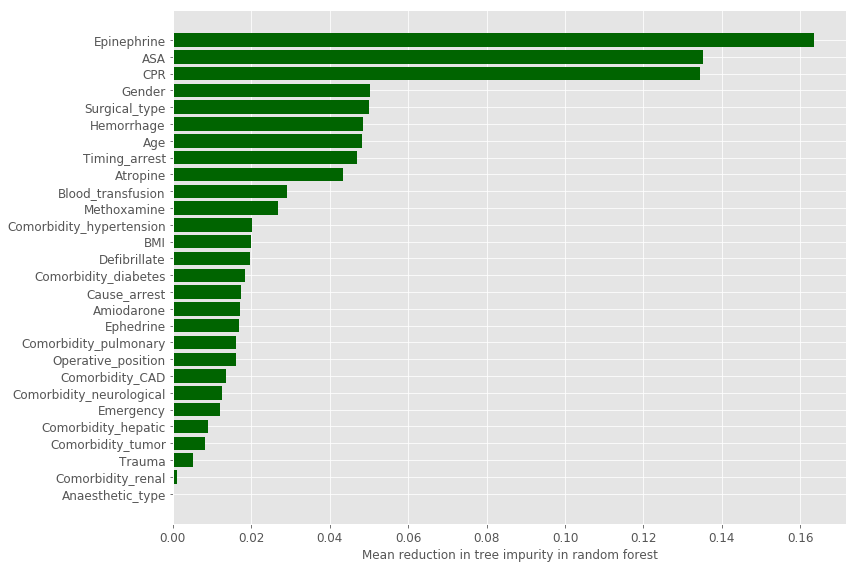

In [157]:
import matplotlib.patches as patches
import matplotlib.colors as colors
import math


# Feature importance dataframe
imp_df = pd.DataFrame({'feature': data.columns.values,
                       'importance': model.feature_importances_})
 
# Reorder by importance
ordered_df = imp_df.sort_values(by='importance')
imp_range=range(1,len(imp_df.index)+1)
 
## Barplot with confidence intervals
height = ordered_df['importance']
bars = ordered_df['feature']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height, color='darkgreen')
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Mean reduction in tree impurity in random forest")

plt.tight_layout()

        
# Show graphic
plt.show()


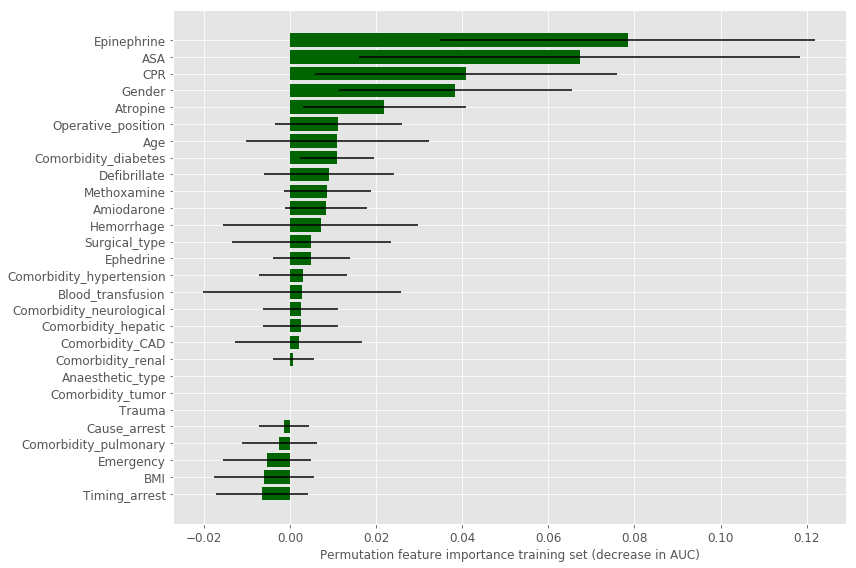

In [158]:
# Feature importance based on TRAINING set

perm_test = PermutationImportance(model, scoring=make_scorer(roc_auc_score),
                                   n_iter=50, random_state=42, cv="prefit")

# fit and see the permuation importances
perm_test.fit(data, data_train['Died'])

imp_df = eli5.explain_weights_df(perm_test)
label_df = pd.DataFrame({'feature': [ "x" + str(i) for i in range(len(data.columns))], 'feature_name': data.columns.values})
imp_df = pd.merge(label_df, imp_df, on='feature', how='inner', validate="one_to_one")
 
# Reorder by importance
ordered_df = imp_df.sort_values(by='weight')
imp_range=range(1,len(imp_df.index)+1)
 

## Barplot with confidence intervals

height = ordered_df['weight']
bars = ordered_df['feature_name']
ci = 1.96 * ordered_df['std']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height, xerr=ci, color='darkgreen')
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Permutation feature importance training set (decrease in AUC)")
plt.tight_layout()

# Show graphic
plt.show()


#### Preparing a LIME explainer

Because LIME takes only float numpy array of the original dataset, to provide a human understandable explanation, it needs to know the mapping from the encoded value to original value for the categorical variables.

This is accomplished through the categorical_names argument. This is a dictionary of a list of values mapped to the index of the (categorical) variable column.

In [33]:
categorical_vals = '''Gender=Female,Male
Age=<12,12~40,40~65,>=65 
BMI= Underweight,Ideal,Overweight,Obese
Surgical_type=Abdominal,Neurosurgery,Orthopedics,Thoracic,Throat,Others
Anaesthetic_type=Local,General
Operative_position=Left lateral decubitus, Right lateral decubitus,Prone,Lithotomy,Supine
ASA=I-III,IV-V
Timing_arrest=Induction,Intubation,Surgery,NotAvaliable
Cause_arrest=Anesthesia,Comorbidity,Surgery,Unknown
Hemorrhage=<200,200~800,>=800 
Blood_transfusion=<200,200~800,>=800 
Epinephrine=0,<=5,>5 
Atropine=0,<=0.65,>0.65
Amiodarone=0,0.04~0.3 
Ephedrine=0,6~15
Methoxamine=0,1~35
CPR=<30,30~60,>=60 '''.split('\n')

categorical_names = {}
for val in categorical_vals:
    categorical_names[categorical_var_idxs[categorical_vars.index(val.split('=')[0])]] = val.split('=')[1].split(',')

In [34]:
categorical_names

{0: ['Female', 'Male'],
 1: ['<12', '12~40', '40~65', '>'],
 2: [' Underweight', 'Ideal', 'Overweight', 'Obese'],
 11: ['Abdominal',
  'Neurosurgery',
  'Orthopedics',
  'Thoracic',
  'Throat',
  'Others'],
 14: ['Local', 'General'],
 15: ['Left lateral decubitus',
  ' Right lateral decubitus',
  'Prone',
  'Lithotomy',
  'Supine'],
 16: ['I-III', 'IV-V'],
 17: ['Induction', 'Intubation', 'Surgery', 'NotAvaliable'],
 19: ['Anesthesia', 'Comorbidity', 'Surgery', 'Unknown'],
 20: ['<200', '200~800', '>'],
 21: ['<200', '200~800', '>'],
 22: ['0', '<'],
 23: ['0', '<'],
 24: ['0', '0.04~0.3 '],
 25: ['0', '6~15'],
 26: ['0', '1~35'],
 27: ['<30', '30~60', '>']}

LIME perturbs the training sample to build a locally linear model to approximate the target model at the test point. 

In [35]:
explainer = LimeTabularExplainer(
    data_train.iloc[:, :-1].values, # remove the target variable from the training set that's fed into LIME
    class_names=['Survived','Died'],
    feature_names=list(data_train.columns),
    categorical_features=categorical_var_idxs,
    categorical_names=categorical_names,
    verbose=True
)

In [36]:
def get_test_sample(model, survived=True, correct=True, seed=42, count=1):
    '''
    Return one random sample from test set based on the selection criteria.
    
    parameters:
      model - the model which is tested for
      survived - select survived sample
      correct - select the sample which the model prediected correctly
    '''
    test_sample = data_test.ix[data_test.Died == (not survived), :-1]
    prediction = model.predict_proba(test_sample)
    
    if (survived and correct) or (not survived and not correct):
        ids = np.argwhere((prediction[:,0] > prediction[:,1]))
    elif (survived and not correct) or (not survived and correct):
        ids = np.argwhere((prediction[:,0] <= prediction[:,1]))
    if count == 1:
        idx = random.Random(seed).choice(ids)   
    else:
        ids = ids.reshape(len(ids)).tolist()
        idx = random.Random(seed).sample(ids, count)
    
    return test_sample.iloc[idx,:]

In [37]:
def plot_vertical_bar(explaination, title='Local explanation for class died'):
    exp_list = explaination.as_list()
    tags, values, colors = [],[],[]
    for i in range(len(exp_list)):
        tags.append(exp_list[i][0])
        values.append(exp_list[i][1])
        if(exp_list[i][1] > 0):
            colors.append('r')
        else:
            colors.append('g')
            
    fig, ax = plt.subplots()

    y_pos = np.arange(len(tags))

    ax.barh(y_pos, values, align='center',
            color=colors, ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(tags)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_title(title)

In [38]:
def score_compare(x, y, threshold = 0.5):
    if x < threshold and y < threshold:
        return 'True Negative'
    elif x < threshold and y > threshold:
        return 'False Negative'
    elif x > threshold and y > threshold:
        return 'True Positive'
    elif x > threshold and y < threshold:
        return 'False Positive'

Intercept 0.6225550352534779
Prediction_local [0.5409325]
Right: 0.475709706959707


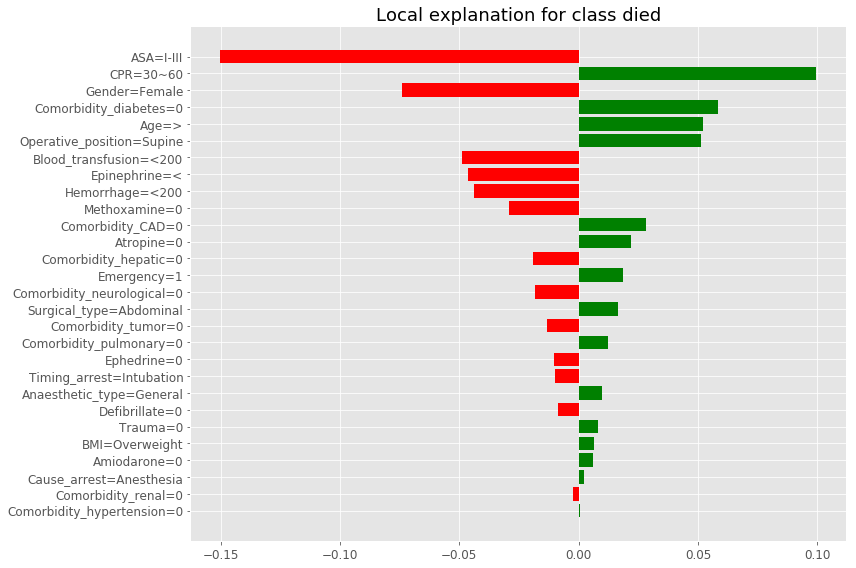

In [169]:
model =model

RANDOM_STATE=42

explainer = LimeTabularExplainer(
    data_train.iloc[:, :-1].values, # remove the target variable from the training set that's fed into LIME
    class_names=['survived','died'],
    feature_names=list(data_train.columns),
    categorical_features=categorical_var_idxs,
    categorical_names=categorical_names,
    mode="classification",
    verbose=True,
    random_state=RANDOM_STATE)


##LIME

#Explain samples in test set
X_explain = data_test.iloc[:, :-1]
#data_test.drop('Died',1)

#Explaining first subject in test set using all 30 features
exp = explainer.explain_instance(X_explain.values[0,:],model.predict_proba, num_features=30)
#Plot local explanation
plt = exp.as_pyplot_figure()
plt.tight_layout()
exp.show_in_notebook(show_table=True)

#### Preparing a SHAP explainer

In [170]:
# explain the model's predictions on test set using SHAP values
# same syntax works for xgboost, LightGBM, CatBoost, and some scikit-learn models
explainer = shap.TreeExplainer(model)

# shap_values consists of a list of two matrices of dimension samplesize x #features
# The first matrix uses average nr of benign samples as base value
# The second matrix which is used below uses average nr of malignant samples as base value 
shap_values = explainer.shap_values(X_explain)


# Interactive visualization of the explanation of the first subject
# in the test set (X_explain).
# It shows the relative contribution of features to get from the base value of malignant
# samples(average value)
# to the output value (1 in case of malignant sample)
# the numbers at the bottom show the actual values for this sample.
shap.initjs() #initialize javascript in cell
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_explain.iloc[0,:])

In [171]:
#Interactive visualization of all sample/feature Shapley values
#It is possible to show the relative contribution of individual features for all
# samples on the y-axis as well.
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_explain)

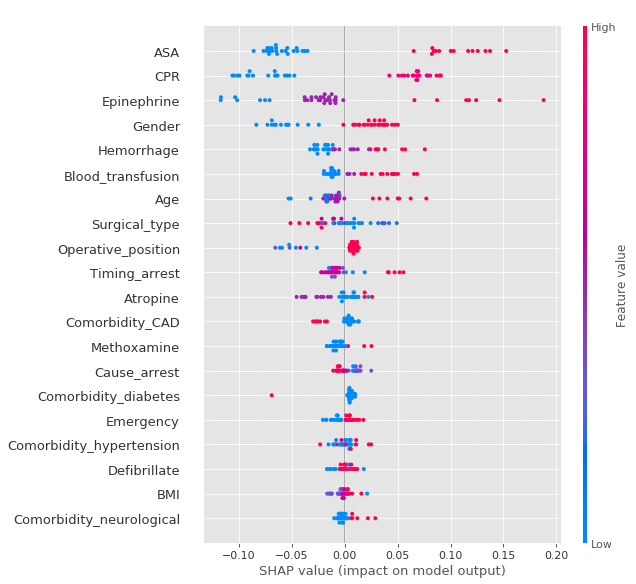

In [172]:
#A summary plot with the shapley value (feature importance) 
shap.summary_plot(shap_values[1], X_explain)

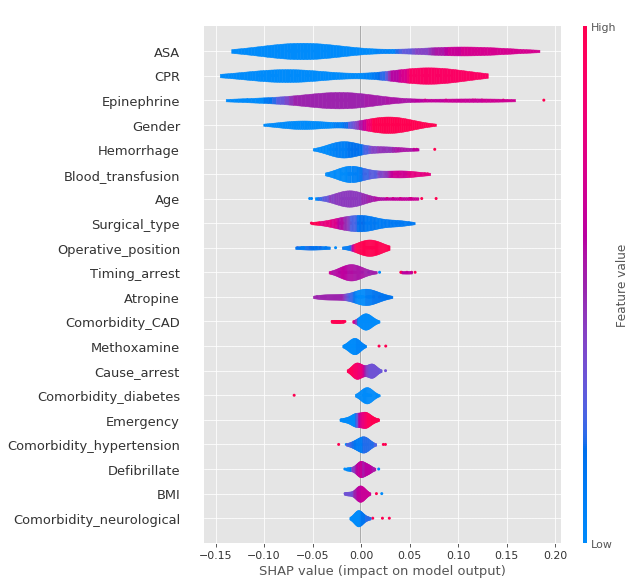

In [173]:
#Same as above, but with violin plots to better see the distribution of shapley values 
shap.summary_plot(shap_values[1], X_explain, plot_type="violin")

In [69]:
test_sample_surived_correct = get_test_sample(ensemble_pipeline, survived=True, correct=True, seed=42, count=1)
test_sample_surived_correct


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
49,1,1,3,0,0,0,0,0,0,0,0,5,0,1,0,4,0,3,0,3,0,0,0,0,0,0,0,1


In [70]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_surived_correct)
score = round(result[0,0],2)
score

0.7

Let's see how LIME explainer (with default settings) explains it.

In [71]:
explaination = explainer.explain_instance(test_sample_surived_correct.values.ravel(), ensemble_pipeline.predict_proba)

Intercept 0.46470802664983524
Prediction_local [0.32398214]
Right: 0.2979098041037179


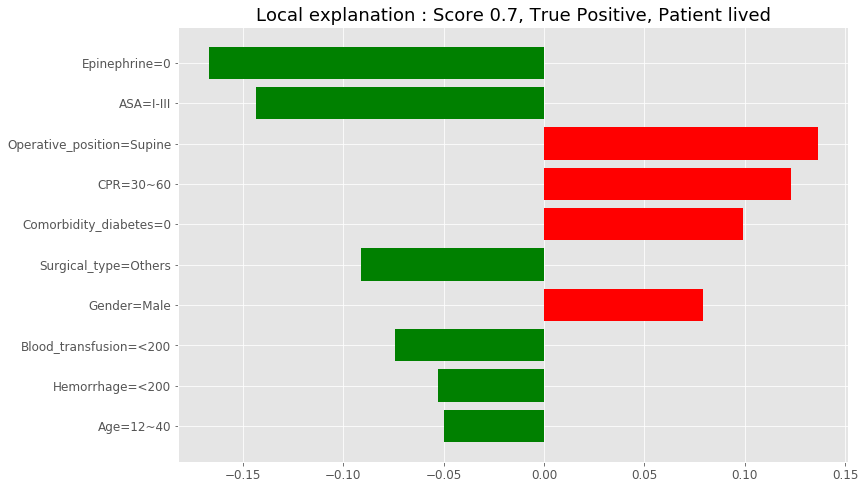

In [72]:
outcome = 1
outcome_title = 'lived'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

In [73]:
test_sample_surived_correct = get_test_sample(ensemble_pipeline, seed=43) #, survived=True, correct=True, seed=42
test_sample_surived_correct


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
95,1,2,2,0,0,1,1,0,0,0,0,5,1,1,1,4,0,0,0,3,0,0,0,1,0,0,0,0


In [74]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_surived_correct)
score = round(result[0,0],2)
score

0.84

Intercept 0.6076972925349214
Prediction_local [0.17648074]
Right: 0.15569744282034187


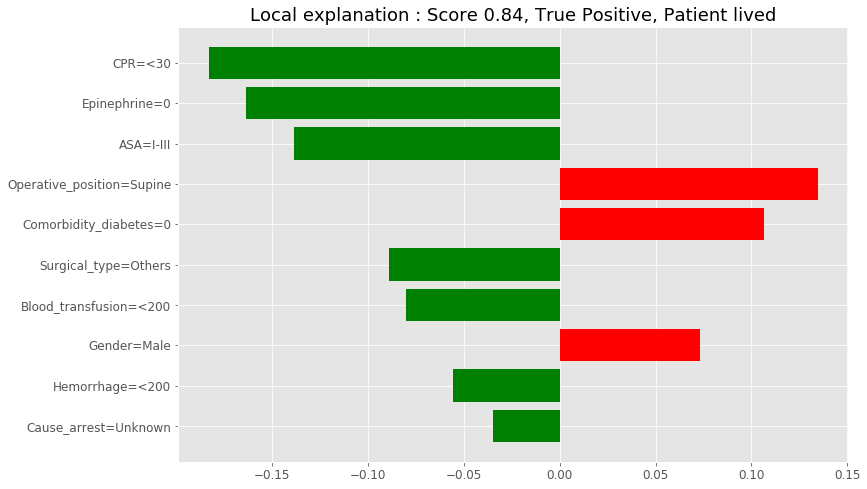

In [75]:
explaination = explainer.explain_instance(test_sample_surived_correct.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 1
outcome_title = 'lived'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

In [76]:
test_sample_surived_correct = get_test_sample(ensemble_pipeline, survived=False, seed=42) #, correct=True, seed=42
test_sample_surived_correct


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
78,1,2,1,0,0,0,1,0,0,0,0,0,1,0,1,4,1,1,1,0,0,0,1,0,0,0,0,1


In [77]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_surived_correct)
score = round(result[0,0],2)
score

0.19

Intercept 0.24432281598415445
Prediction_local [0.77883465]
Right: 0.810514307317796


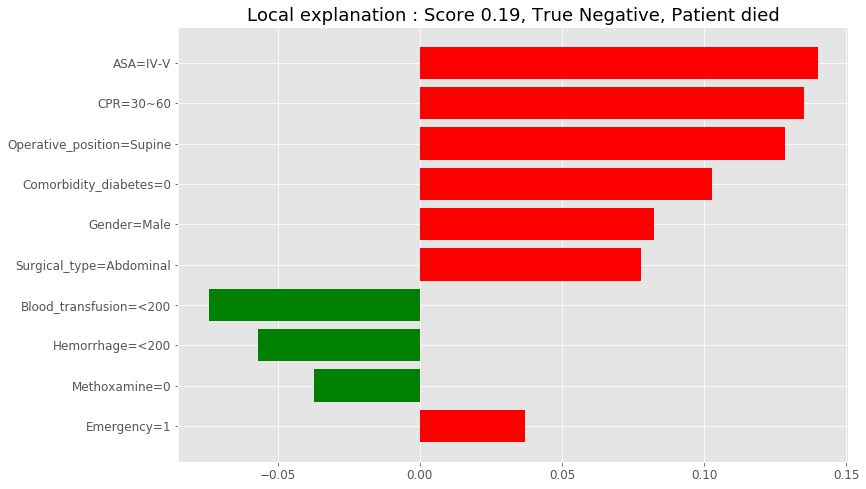

In [78]:
explaination = explainer.explain_instance(test_sample_surived_correct.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 0
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

In [79]:
test_sample_surived_correct = get_test_sample(ensemble_pipeline, survived=False, seed=47) #, correct=True, seed=42
test_sample_surived_correct


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
69,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,2,1,1,2,2,1,1,0,0,0,1


In [80]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_surived_correct)
score = round(result[0,0],2)
score

0.12

Intercept 0.11075063141401242
Prediction_local [0.99459309]
Right: 0.8815194813533183


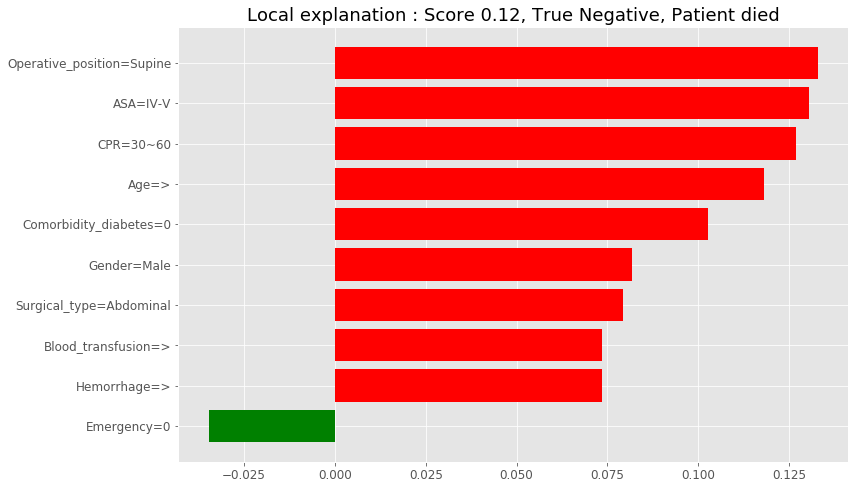

In [81]:
explaination = explainer.explain_instance(test_sample_surived_correct.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 0
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

## Incorrect, person died, score 52%

In [82]:
test_sample_incorrect = get_test_sample(ensemble_pipeline, correct=False, survived=False, seed=42) #, correct=True, seed=42
test_sample_incorrect


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
101,0,1,2,0,0,0,0,0,1,0,0,0,1,0,1,4,0,2,0,3,2,2,1,1,0,0,0,0


In [83]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_incorrect)
score = round(result[0,0],2)
score

0.52

Intercept 0.5106241123660451
Prediction_local [0.48566301]
Right: 0.4813893697166585


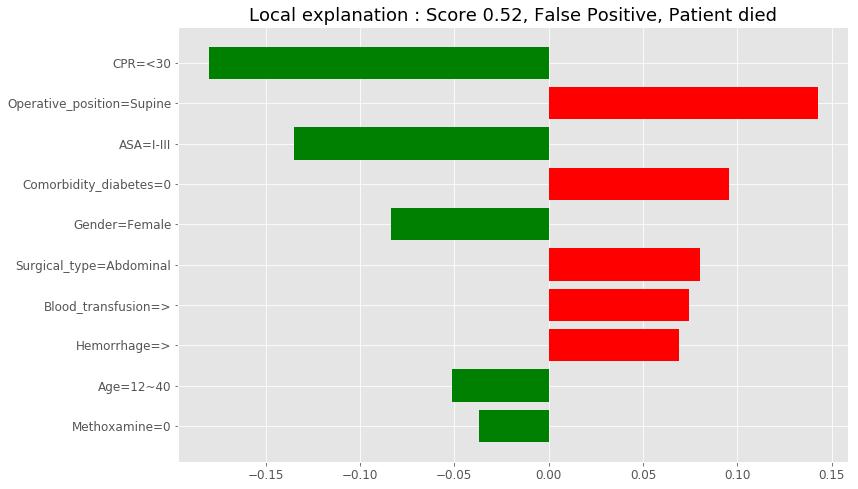

In [84]:
explaination = explainer.explain_instance(test_sample_incorrect.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 0
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

## Incorrect, person died, score 77%

In [85]:
test_sample_incorrect = get_test_sample(ensemble_pipeline, correct=False, survived=False, seed=58) #, correct=True, seed=42
test_sample_incorrect


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
101,0,1,2,0,0,0,0,0,1,0,0,0,1,0,1,4,0,2,0,3,2,2,1,1,0,0,0,0


In [86]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_incorrect)
score = round(result[0,0],2)
score

0.52

Intercept 0.4750188310160778
Prediction_local [0.46449472]
Right: 0.4813893697166585


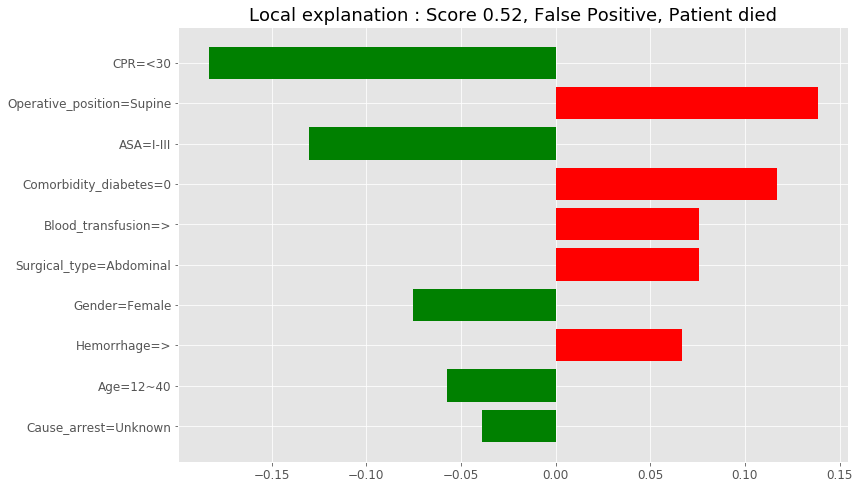

In [87]:
explaination = explainer.explain_instance(test_sample_incorrect.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 0
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

## Incorrect, person lived, score 29%

In [88]:
test_sample_incorrect = get_test_sample(ensemble_pipeline, correct=False, survived=True, seed=4) #, correct=True, seed=42
test_sample_incorrect


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
131,1,3,2,0,1,1,0,0,0,1,0,0,1,0,1,4,1,1,1,0,0,1,2,1,0,0,0,0


In [91]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_incorrect)
score = round(result[0,0],2)
score

0.18

In [92]:
explaination = explainer.explain_instance(test_sample_incorrect.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 1
outcome_title = 'lived'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

IndexError: list index out of range

## Incorrect, Person lived, Score 22%

In [93]:
test_sample_incorrect = get_test_sample(ensemble_pipeline, correct=False, survived=True, seed=48) #, correct=True, seed=42
test_sample_incorrect


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
124,1,2,1,0,0,0,0,0,0,0,1,0,0,0,1,3,0,2,1,3,2,2,2,0,0,0,1,0


In [94]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_incorrect)
score = round(result[0,0],2)
score

0.41

In [95]:
explaination = explainer.explain_instance(test_sample_incorrect.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 1
outcome_title = 'lived'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

IndexError: list index out of range